In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import os
import sys
import pickle
import math
import matplotlib

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

import neurolib.dashboard.data as data
from neurolib.models.aln import ALNModel
import neurolib.dashboard.layout as layout
import neurolib.dashboard.functions as functions
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import func_optimize as fo
from neurolib.utils import costFunctions as cost


# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2    

not here


In [2]:
readpath = '.' + os.sep

with open(readpath + os.sep + 'bi.pickle','rb') as file:
    load_array= pickle.load(file)
ext_exc = load_array[0]
ext_inh = load_array[1]

with open(readpath + os.sep + 'bi_granular.pickle','rb') as file:
    load_array= pickle.load(file)
ext_exc_granular = load_array[0]
ext_inh_granular = load_array[1]

with open(readpath + os.sep + 'boundary_bi_granular.pickle','rb') as file:
    load_array= pickle.load(file)
boundary_exc_granular = load_array[0]
boundary_inh_granular = load_array[1]

grid_resolution = layout.grid_resolution
grid_resolution_granular = layout.grid_resolution_granular

dist_up_regime = np.zeros((len(ext_exc), 2))
dist_down_regime = np.zeros((len(ext_exc)))

cmap = layout.getcolormap()
darkgrey, midgrey, lightgrey, color_bi_updown, color_LC, color_bi_uposc = layout.getcolors()
exc_red = cmap(3)
inh_blue=cmap(0)
green = cmap(2)

aln = ALNModel()
data.set_parameters(aln)
state_vars = aln.state_vars

#facecolor_ = '#EAEAEA'
facecolor_ = 'white'

In [3]:
readpath = '.' + os.sep
savepath = os.path.join(os.getcwd().split('neurolib')[0], 'Talks_Conf_Workshops_Schools'
                        + os.sep + '2022_Symposium' + os.sep + 'Talk' + os.sep + 'images')

with open(readpath + os.sep + 'bi.pickle','rb') as file:
    load_array= pickle.load(file)
ext_exc = load_array[0]
ext_inh = load_array[1]

grid_resolution = layout.grid_resolution

dist_up_regime = np.zeros((len(ext_exc), 2))
dist_down_regime = np.zeros((len(ext_exc)))

cmap = layout.getcolormap()
darkgrey, midgrey, lightgrey, color_bi_updown, color_LC, color_bi_uposc = layout.getcolors()
exc_red = cmap(3)
inh_blue=cmap(0)
green = cmap(2)

aln = ALNModel()
data.set_parameters(aln)
state_vars = aln.state_vars

In [36]:
##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]

def readcase(case_, readpath):
    
    global ind_, type_, mu_e, mu_i, a_e, a_i, cost_node, w_e, w_i, target_high, target_low 
    global d_e, d_i, d_total
    
    data_array = data.read_data_1(aln, readpath, case_)
    ind_, type_, mu_e, mu_i, a_, cost_node, w_, target_high, target_low = data_array
    
    opt_control = [None] * len(ind_)
    opt_state = [None] * len(ind_)
    
    control_data = data.read_control(readpath, case_)
    opt_control = control_data[2]
    opt_state = control_data[3]
    
    
        
    d_e = [None] * len(ind_)
    d_i = [None] * len(ind_)
    a_e = [None] * len(ind_)
    a_i = [None] * len(ind_)
    d_total = [None] * len(ind_)
    
    for i in ind_:
        
        if type(opt_control[i]) == type(None):
            continue
            
        if ( np.amax(opt_control[i][:,0,:]) + aln.params.Jee_max * opt_state[i][0,5,0] > aln.params.Jee_max
            or np.amin(opt_control[i][:,0,:]) + aln.params.Jei_max * opt_state[i][0,6,0] < aln.params.Jei_max
            or np.amax(opt_control[i][:,1,:]) + aln.params.Jie_max * opt_state[i][0,7,0]> aln.params.Jie_max
            or np.amin(opt_control[i][:,1,:]) + aln.params.Jii_max * opt_state[i][0,8,0] < aln.params.Jii_max ):
            print("Control amplitude beyond maximal synaptic current, ", i)
            print( np.amax(opt_control[i][:,0,:]) , aln.params.Jee_max )
            print( np.amin(opt_control[i][:,0,:]) , aln.params.Jei_max)
            print( np.amax(opt_control[i][:,1,:]) , aln.params.Jie_max )
            print( np.amin(opt_control[i][:,1,:]) , aln.params.Jii_max )
            
            
        a_e[i] = a_[0,i]
        a_i[i] = a_[1,i]
        
        if case_ in ['1', '2']:
            d_e[i] = data.dist_right(mu_e[i], mu_i[i], ext_exc_granular, ext_inh_granular, grid_resolution)
            d_i[i] = data.dist_low(mu_e[i], mu_i[i], ext_exc_granular, ext_inh_granular, grid_resolution)
            d_total[i] = data.dist_up_regime(mu_e[i], mu_i[i], boundary_exc_granular, boundary_inh_granular,
                                                   grid_resolution_granular)
        else:
            d_e[i] = data.dist_left(mu_e[i], mu_i[i], ext_exc_granular, ext_inh_granular, grid_resolution)
            d_i[i] = data.dist_up(mu_e[i], mu_i[i], ext_exc_granular, ext_inh_granular, grid_resolution)
            d_total[i] = data.dist_down_regime(mu_e[i], mu_i[i], boundary_exc_granular, boundary_inh_granular,
                                               grid_resolution_granular)

In [28]:
case = '2'
c_type = 'current'
readpath = '.' + os.sep + 'data_final_' + c_type + os.sep
readcase(case, readpath)

case =  ./data_final_current/ 2
1.0912765078735516
1.0912765078735516
0.40536542549871507
case =  ./data_final_current/ 2
1.0912765078735516
Control amplitude beyond maximal synaptic current,  62
1.1964058051381408 2.43
0.0 -3.3
0.0 2.6
-1.6757982106098177 -1.64
Control amplitude beyond maximal synaptic current,  69
1.313862688366429 2.43
0.0 -3.3
3.1313219841137386e-07 2.6
-1.8069846516331722 -1.64


In [5]:
##### LOAD BOUNDARIES
with open('boundary_bi_granular.pickle','rb') as file:
    load_array= pickle.load(file)
boundary_bi_exc = load_array[0]
boundary_bi_inh = load_array[1]

with open('bi.pickle','rb') as file:
    load_array= pickle.load(file)
bi_exc = load_array[0]
bi_inh = load_array[1]

with open('boundary_LC_granular.pickle','rb') as file:
    load_array= pickle.load(file)
boundary_LC_exc = load_array[0]
boundary_LC_inh = load_array[1]

with open('boundary_LCbi_granular.pickle','rb') as file:
    load_array= pickle.load(file)
boundary_LC_up_exc = load_array[0]
boundary_LC_up_inh = load_array[1]


fontsize_ = 32
fontsize_small = 20

case =  ./data_final_current/ 1
case =  ./data_final_current/ 1


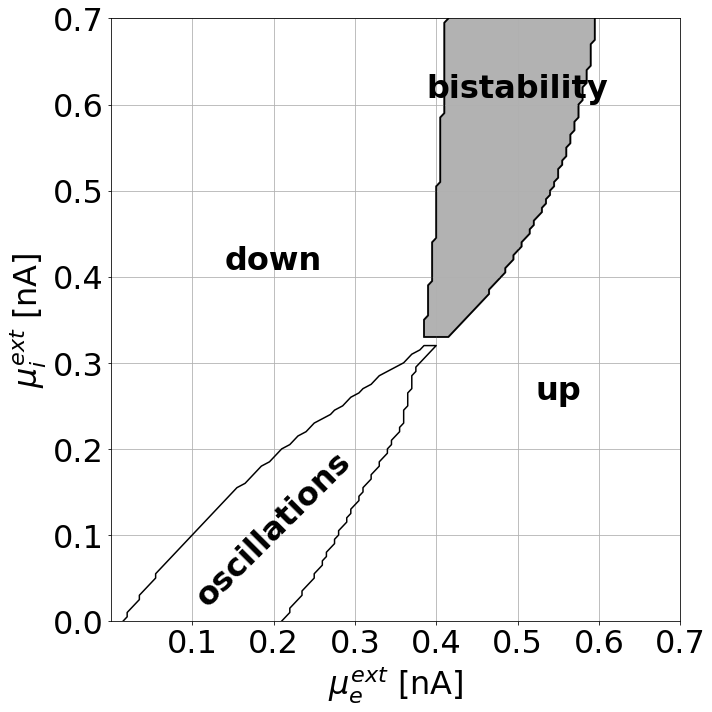

In [6]:
readpath = '.' + os.sep + 'data_final_current' + os.sep
readcase('1', readpath) 

fig, ax = plt.subplots(figsize = (10,10), facecolor=facecolor_)
ax.set_ylim(0., .7)
ax.set_xlim(0., .7)
ax.set_xticks(np.arange(0.1, 0.8, 0.1))

vertices = np.zeros(( len(boundary_bi_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_bi_exc[i]
    vertices[i,1] = boundary_bi_inh[i]
path = mpath.Path(vertices)

patch = patches.PathPatch(path, facecolor='grey', alpha=0.6, lw=2)
ax.add_patch(patch)

x, y = zip(*path.vertices)
line, = ax.plot(x, y, markersize=0, color='black')

vertices = np.zeros(( len(boundary_LC_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_LC_exc[i]
    vertices[i,1] = boundary_LC_inh[i]
path = mpath.Path(vertices)
x, y = zip(*path.vertices)
line, = ax.plot(x, y, color='black')

bistable_regime = layout.get_bistable_paths(boundary_bi_exc, boundary_bi_inh)
oscillatory_regime = layout.get_osc_path(boundary_LC_exc, boundary_LC_inh)
LC_up_regime = layout.get_LC_up_path(boundary_LC_up_exc, boundary_LC_up_inh)


x_, y_ = 0.5, 0.6
ax.annotate('bistability', xy=(x_, y_),  xycoords='data',
        xytext=(x_, y_), textcoords='data', fontsize=fontsize_,
        horizontalalignment='center', verticalalignment='bottom', weight='bold'
        )
x_, y_ = 0.2, 0.01
ax.annotate('oscillations', xy=(x_, y_),  xycoords='data',
        xytext=(x_, y_), textcoords='data', fontsize=fontsize_,
        horizontalalignment='center', verticalalignment='bottom', weight='bold', rotation=45, zorder=10
        )
x_, y_ = 0.2, 0.4
ax.annotate('down', xy=(x_, y_),  xycoords='data',
        xytext=(x_, y_), textcoords='data', fontsize=fontsize_,
        horizontalalignment='center', verticalalignment='bottom', weight='bold'
        )
x_, y_ = 0.55, 0.25
ax.annotate('up', xy=(x_, y_),  xycoords='data',
        xytext=(x_, y_), textcoords='data', fontsize=fontsize_,
        horizontalalignment='center', verticalalignment='bottom', weight='bold'
        )
    
ax.set_xlabel(r'$\mu_e^{ext}$ [nA]', fontsize=fontsize_)
ax.set_ylabel(r'$\mu_i^{ext}$ [nA]', fontsize=fontsize_)
ax.tick_params(axis='x', labelsize=fontsize_)
ax.tick_params(axis='y', labelsize=fontsize_)

fig.tight_layout()
        
plt.savefig(os.path.join(os.getcwd(), 'bifurcation_0.jpg'), bbox_inches='tight', facecolor=fig.get_facecolor(), edgecolor='none', dpi=300 )
plt.savefig(os.path.join(savepath, 'bifurcation_0.jpg'), bbox_inches='tight', facecolor=fig.get_facecolor(), edgecolor='none', dpi=300 )

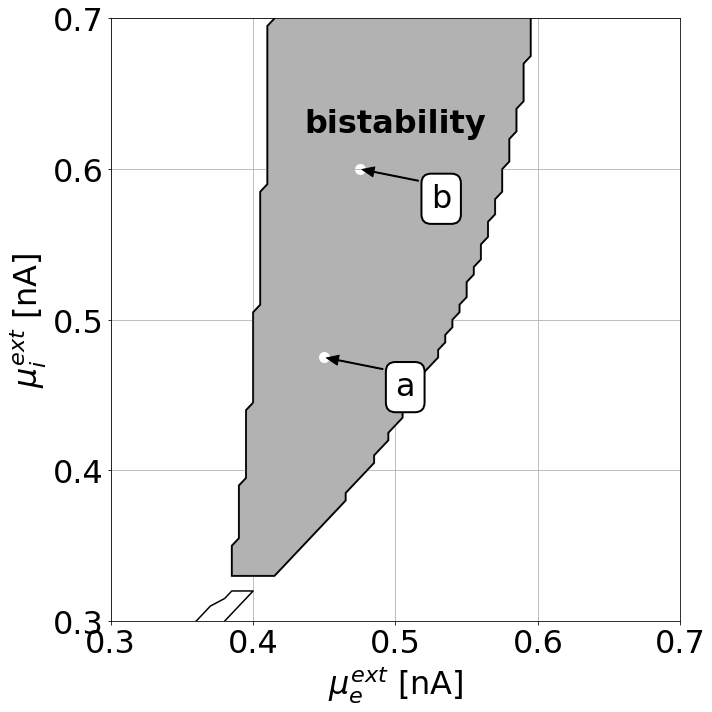

In [7]:
fig, ax = plt.subplots(figsize = (10,10), facecolor=facecolor_)
ax.set_ylim(0.35, .7)
ax.set_xlim(0.3, .7)
ax.set_xticks(np.arange(0.3, 0.8, 0.1))
ax.set_yticks(np.arange(0.3, 0.8, 0.1))

vertices = np.zeros(( len(boundary_bi_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_bi_exc[i]
    vertices[i,1] = boundary_bi_inh[i]
path = mpath.Path(vertices)

patch = patches.PathPatch(path, facecolor='grey', alpha=0.6, lw=2)
ax.add_patch(patch)

x, y = zip(*path.vertices)
line, = ax.plot(x, y, markersize=0, color='black')

vertices = np.zeros(( len(boundary_LC_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_LC_exc[i]
    vertices[i,1] = boundary_LC_inh[i]
path = mpath.Path(vertices)
x, y = zip(*path.vertices)
line, = ax.plot(x, y, color='black')

bistable_regime = layout.get_bistable_paths(boundary_bi_exc, boundary_bi_inh)
oscillatory_regime = layout.get_osc_path(boundary_LC_exc, boundary_LC_inh)
LC_up_regime = layout.get_LC_up_path(boundary_LC_up_exc, boundary_LC_up_inh)


x_, y_ = 0.5, 0.62
ax.annotate('bistability', xy=(x_, y_),  xycoords='data',
        xytext=(x_, y_), textcoords='data', fontsize=fontsize_,
        horizontalalignment='center', verticalalignment='bottom', weight='bold'
        )
x_, y_ = 0.2, 0.01
ax.annotate('oscillations', xy=(x_, y_),  xycoords='data',
        xytext=(x_, y_), textcoords='data', fontsize=fontsize_,
        horizontalalignment='center', verticalalignment='bottom', weight='bold', rotation=45, zorder=10
        )
x_, y_ = 0.2, 0.4
ax.annotate('down', xy=(x_, y_),  xycoords='data',
        xytext=(x_, y_), textcoords='data', fontsize=fontsize_,
        horizontalalignment='center', verticalalignment='bottom', weight='bold'
        )
x_, y_ = 0.55, 0.25
ax.annotate('up', xy=(x_, y_),  xycoords='data',
        xytext=(x_, y_), textcoords='data', fontsize=fontsize_,
        horizontalalignment='center', verticalalignment='bottom', weight='bold'
        )
x_ = ext_exc[20]
y_ = ext_inh[20]
ax.plot(x_, y_, 'o', color=facecolor_, markersize=10, zorder=1)
ax.annotate('a', xy=(x_, y_),  xycoords='data',
        xytext=(x_ + 0.05, y_ - 0.03), textcoords='data', fontsize=fontsize_,
        arrowprops=dict(facecolor='black', shrink=0.03, headwidth=10, width=1),
        horizontalalignment='left', verticalalignment='bottom',
        bbox=dict(boxstyle="round,pad=0.3", fc=facecolor_, ec="black", lw=2)
        )
x_ = ext_exc[50]
y_ = ext_inh[50]
ax.plot(x_, y_, 'o', color=facecolor_, markersize=10, zorder=1)
ax.annotate('b', xy=(x_, y_),  xycoords='data',
        xytext=(x_ + 0.05, y_ - 0.03), textcoords='data', fontsize=fontsize_,
        arrowprops=dict(facecolor='black', shrink=0.03, headwidth=10, width=1),
        horizontalalignment='left', verticalalignment='bottom',
        bbox=dict(boxstyle="round,pad=0.3", fc=facecolor_, ec="black", lw=2)
        )

    
ax.set_xlabel(r'$\mu_e^{ext}$ [nA]', fontsize=fontsize_)
ax.set_ylabel(r'$\mu_i^{ext}$ [nA]', fontsize=fontsize_)
ax.tick_params(axis='x', labelsize=fontsize_)
ax.tick_params(axis='y', labelsize=fontsize_)

fig.tight_layout()
        
plt.savefig(os.path.join(os.getcwd(), 'bifurcation_points_ab.jpg'), bbox_inches='tight',
            facecolor=fig.get_facecolor(), edgecolor='none', dpi=300 )
plt.savefig(os.path.join(savepath, 'bifurcation_points_ab.jpg'), bbox_inches='tight',
            facecolor=fig.get_facecolor(), edgecolor='none', dpi=300 )

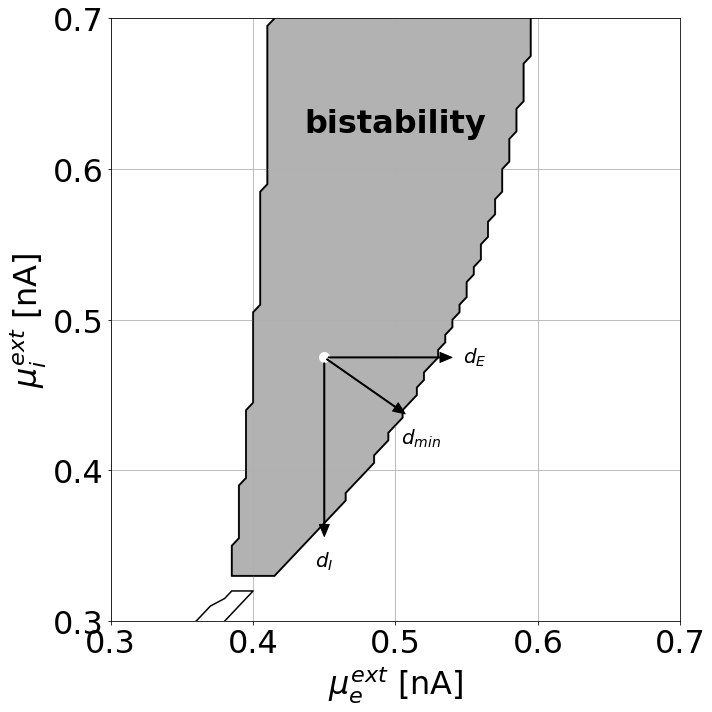

In [17]:
fig, ax = plt.subplots(figsize = (10,10), facecolor=facecolor_)
ax.set_ylim(0.35, .7)
ax.set_xlim(0.3, .7)
ax.set_xticks(np.arange(0.3, 0.8, 0.1))
ax.set_yticks(np.arange(0.3, 0.8, 0.1))

vertices = np.zeros(( len(boundary_bi_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_bi_exc[i]
    vertices[i,1] = boundary_bi_inh[i]
path = mpath.Path(vertices)

patch = patches.PathPatch(path, facecolor='grey', alpha=0.6, lw=2)
ax.add_patch(patch)

x, y = zip(*path.vertices)
line, = ax.plot(x, y, markersize=0, color='black')

vertices = np.zeros(( len(boundary_LC_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_LC_exc[i]
    vertices[i,1] = boundary_LC_inh[i]
path = mpath.Path(vertices)
x, y = zip(*path.vertices)
line, = ax.plot(x, y, color='black')

bistable_regime = layout.get_bistable_paths(boundary_bi_exc, boundary_bi_inh)
oscillatory_regime = layout.get_osc_path(boundary_LC_exc, boundary_LC_inh)
LC_up_regime = layout.get_LC_up_path(boundary_LC_up_exc, boundary_LC_up_inh)


x_, y_ = 0.5, 0.62
ax.annotate('bistability', xy=(x_, y_),  xycoords='data',
        xytext=(x_, y_), textcoords='data', fontsize=fontsize_,
        horizontalalignment='center', verticalalignment='bottom', weight='bold'
        )
x_, y_ = 0.2, 0.01
ax.annotate('oscillations', xy=(x_, y_),  xycoords='data',
        xytext=(x_, y_), textcoords='data', fontsize=fontsize_,
        horizontalalignment='center', verticalalignment='bottom', weight='bold', rotation=45, zorder=10
        )
x_, y_ = 0.2, 0.4
ax.annotate('down', xy=(x_, y_),  xycoords='data',
        xytext=(x_, y_), textcoords='data', fontsize=fontsize_,
        horizontalalignment='center', verticalalignment='bottom', weight='bold'
        )
x_, y_ = 0.55, 0.25
ax.annotate('up', xy=(x_, y_),  xycoords='data',
        xytext=(x_, y_), textcoords='data', fontsize=fontsize_,
        horizontalalignment='center', verticalalignment='bottom', weight='bold'
        )
x_ = ext_exc[20]
y_ = ext_inh[20]
ax.plot(x_, y_, 'o', color=facecolor_, markersize=10, zorder=1)
ax.annotate('', xy=(x_ + d_e[20], y_),  xycoords='data',
        xytext=(x_, y_), textcoords='data', fontsize=fontsize_small,
        arrowprops=dict(facecolor='black', shrink=0.03, headwidth=10, width=1),
        horizontalalignment='right', verticalalignment='bottom'
        )
ax.annotate('', xy=(x_ , y_ - d_i[20]),  xycoords='data',
        xytext=(x_, y_), textcoords='data', fontsize=fontsize_small,
        arrowprops=dict(facecolor='black', shrink=0.03, headwidth=10, width=1),
        horizontalalignment='right', verticalalignment='bottom'
        )
ax.annotate('', xy=(x_ + d_total[20]/np.sqrt(2.) + 0.01, y_ - d_total[20]/np.sqrt(2.) + 0.01),  xycoords='data',
        xytext=(x_, y_), textcoords='data', fontsize=fontsize_small, arrowprops=dict(facecolor='black', shrink=0.03,
        headwidth=10, width=1), horizontalalignment='right', verticalalignment='bottom'
        )
ax.annotate(r'$d_E$', xy=(x_ + d_e[20] + 0.005, y_),  xycoords='data',
        xytext=(x_ + d_e[20] + 0.005, y_), textcoords='data', fontsize=fontsize_small,
        horizontalalignment='left', verticalalignment='center'
        )
ax.annotate(r'$d_I$', xy=(x_, y_ - d_i[20] - 0.005),  xycoords='data',
        xytext=(x_, y_ - d_i[20] - 0.005), textcoords='data', fontsize=fontsize_small,
        horizontalalignment='center', verticalalignment='top'
        )
ax.annotate(r'$d_{min}$', xy=(x_ + d_total[20]/np.sqrt(2.) + 0.005, y_ - d_total[20]/np.sqrt(2.) - 0.005), 
        xycoords='data', xytext=(x_ + d_total[20]/np.sqrt(2.) + 0.005, y_ - d_total[20]/np.sqrt(2.) - 0.005),
        textcoords='data', fontsize=fontsize_small, horizontalalignment='left', verticalalignment='center'
        )

    
ax.set_xlabel(r'$\mu_e^{ext}$ [nA]', fontsize=fontsize_)
ax.set_ylabel(r'$\mu_i^{ext}$ [nA]', fontsize=fontsize_)
ax.tick_params(axis='x', labelsize=fontsize_)
ax.tick_params(axis='y', labelsize=fontsize_)

fig.tight_layout()
        
plt.savefig(os.path.join(os.getcwd(), 'bifurcation_d.jpg'), bbox_inches='tight', 
            facecolor=fig.get_facecolor(), edgecolor='none', dpi=300 )
plt.savefig(os.path.join(savepath, 'bifurcation_d.jpg'), bbox_inches='tight', 
            facecolor=fig.get_facecolor(), edgecolor='none', dpi=300, transparent=True )

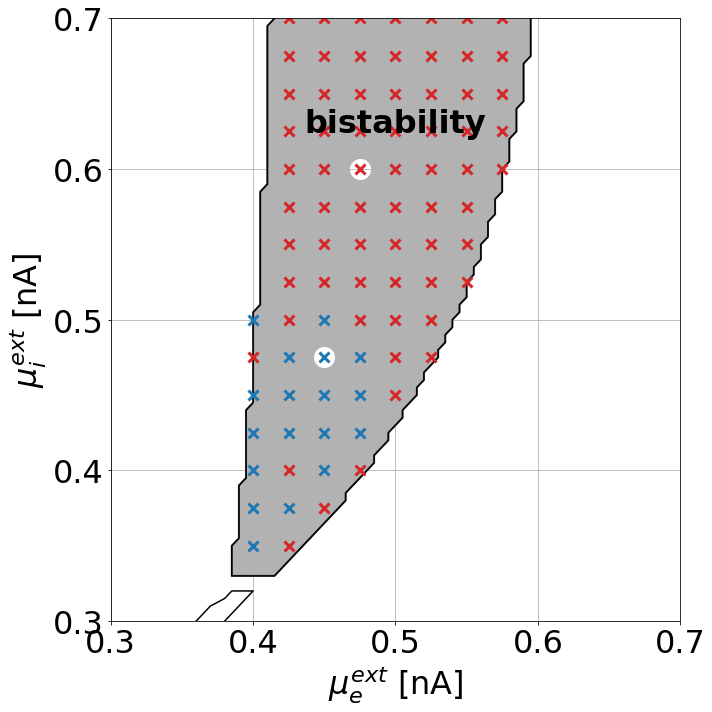

In [23]:
fig, ax = plt.subplots(figsize = (10,10), facecolor=facecolor_)
ax.set_ylim(0.35, .7)
ax.set_xlim(0.3, .7)
ax.set_xticks(np.arange(0.3, 0.8, 0.1))
ax.set_yticks(np.arange(0.3, 0.8, 0.1))

vertices = np.zeros(( len(boundary_bi_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_bi_exc[i]
    vertices[i,1] = boundary_bi_inh[i]
path = mpath.Path(vertices)

patch = patches.PathPatch(path, facecolor='grey', alpha=0.6, lw=2)
ax.add_patch(patch)
ax.set_facecolor(facecolor_)

x, y = zip(*path.vertices)
line, = ax.plot(x, y, markersize=0, color='black')

vertices = np.zeros(( len(boundary_LC_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_LC_exc[i]
    vertices[i,1] = boundary_LC_inh[i]
path = mpath.Path(vertices)
x, y = zip(*path.vertices)
line, = ax.plot(x, y, color='black')

bistable_regime = layout.get_bistable_paths(boundary_bi_exc, boundary_bi_inh)
oscillatory_regime = layout.get_osc_path(boundary_LC_exc, boundary_LC_inh)
LC_up_regime = layout.get_LC_up_path(boundary_LC_up_exc, boundary_LC_up_inh)

for i in range(len(ext_exc)):
    if type(a_e[i]) == type(None):
        continue

    if np.abs(a_e[i]) > np.abs(a_i[i]):
        ax.plot(ext_exc[i], ext_inh[i], 'x', color=exc_red, markersize=10, markeredgewidth=3)
    else:
        ax.plot(ext_exc[i], ext_inh[i], 'x', color=inh_blue, markersize=10, markeredgewidth=3)

x_, y_ = 0.5, 0.62
ax.annotate('bistability', xy=(x_, y_),  xycoords='data',
        xytext=(x_, y_), textcoords='data', fontsize=fontsize_,
        horizontalalignment='center', verticalalignment='bottom', weight='bold'
        )

x_ = ext_exc[20]
y_ = ext_inh[20]
ax.plot(x_, y_, 'o', color=facecolor_, markersize=20, zorder=1)

x_ = ext_exc[50]
y_ = ext_inh[50]
ax.plot(x_, y_, 'o', color=facecolor_, markersize=20, zorder=1)

ax.set_xlabel(r'$\mu_e^{ext}$ [nA]', fontsize=fontsize_)
ax.set_ylabel(r'$\mu_i^{ext}$ [nA]', fontsize=fontsize_)
ax.tick_params(axis='x', labelsize=fontsize_)
ax.tick_params(axis='y', labelsize=fontsize_)

fig.tight_layout()
        
plt.savefig(os.path.join(os.getcwd(), 'bifurcation_task1.jpg'), bbox_inches='tight',
            #facecolor=fig.get_facecolor(), 
            edgecolor='none', dpi=300 )
plt.savefig(os.path.join(savepath, 'bifurcation_task1.png'), bbox_inches='tight',
            #facecolor=fig.get_facecolor(), 
            edgecolor='none', dpi=300, transparent=True)

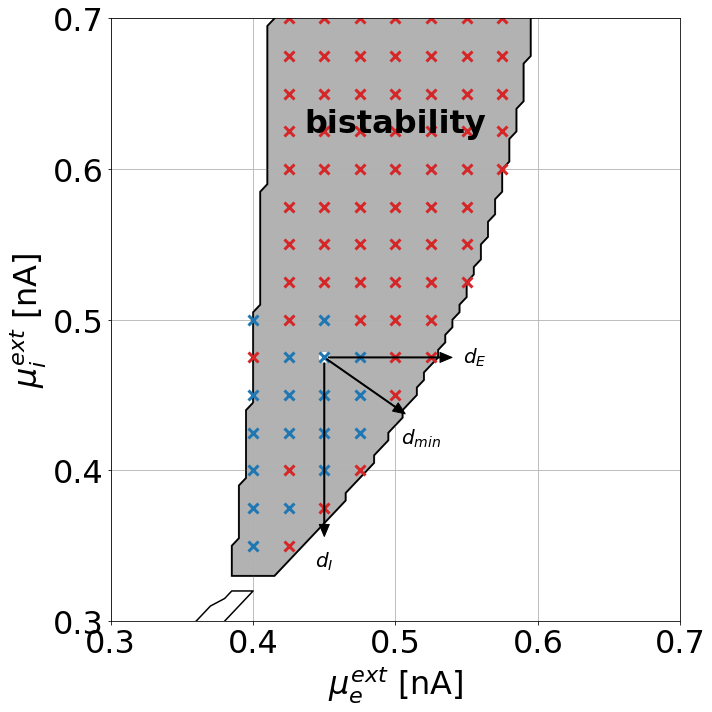

In [13]:
fig, ax = plt.subplots(figsize = (10,10), facecolor=facecolor_, alpha=1)
ax.set_ylim(0.35, .7)
ax.set_xlim(0.3, .7)
ax.set_xticks(np.arange(0.3, 0.8, 0.1))
ax.set_yticks(np.arange(0.3, 0.8, 0.1))

vertices = np.zeros(( len(boundary_bi_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_bi_exc[i]
    vertices[i,1] = boundary_bi_inh[i]
path = mpath.Path(vertices)

patch = patches.PathPatch(path, facecolor='grey', alpha=0.6, lw=2)
ax.add_patch(patch)

x, y = zip(*path.vertices)
line, = ax.plot(x, y, markersize=0, color='black')

vertices = np.zeros(( len(boundary_LC_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_LC_exc[i]
    vertices[i,1] = boundary_LC_inh[i]
path = mpath.Path(vertices)
x, y = zip(*path.vertices)
line, = ax.plot(x, y, color='black')

bistable_regime = layout.get_bistable_paths(boundary_bi_exc, boundary_bi_inh)
oscillatory_regime = layout.get_osc_path(boundary_LC_exc, boundary_LC_inh)
LC_up_regime = layout.get_LC_up_path(boundary_LC_up_exc, boundary_LC_up_inh)

for i in range(len(ext_exc)):
    if type(a_e[i]) == type(None):
        continue

    if np.abs(a_e[i]) > np.abs(a_i[i]):
        ax.plot(ext_exc[i], ext_inh[i], 'x', color=exc_red, markersize=10, markeredgewidth=3)
    else:
        ax.plot(ext_exc[i], ext_inh[i], 'x', color=inh_blue, markersize=10, markeredgewidth=3)

x_, y_ = 0.5, 0.62
ax.annotate('bistability', xy=(x_, y_),  xycoords='data',
        xytext=(x_, y_), textcoords='data', fontsize=fontsize_,
        horizontalalignment='center', verticalalignment='bottom', weight='bold'
        )

x_ = ext_exc[20]
y_ = ext_inh[20]
ax.plot(x_, y_, 'o', color=facecolor_, markersize=10, zorder=1)


ax.annotate('', xy=(x_ + d_e[20], y_),  xycoords='data',
        xytext=(x_, y_), textcoords='data', fontsize=fontsize_small,
        arrowprops=dict(facecolor='black', shrink=0.03, headwidth=10, width=1),
        horizontalalignment='right', verticalalignment='bottom'
        )
ax.annotate('', xy=(x_ , y_ - d_i[20]),  xycoords='data',
        xytext=(x_, y_), textcoords='data', fontsize=fontsize_small,
        arrowprops=dict(facecolor='black', shrink=0.03, headwidth=10, width=1),
        horizontalalignment='right', verticalalignment='bottom'
        )
ax.annotate('', xy=(x_ + d_total[20]/np.sqrt(2.) + 0.01, y_ - d_total[20]/np.sqrt(2.) + 0.01),  xycoords='data',
        xytext=(x_, y_), textcoords='data', fontsize=fontsize_small, arrowprops=dict(facecolor='black', shrink=0.03,
        headwidth=10, width=1), horizontalalignment='right', verticalalignment='bottom'
        )
ax.annotate(r'$d_E$', xy=(x_ + d_e[20] + 0.005, y_),  xycoords='data',
        xytext=(x_ + d_e[20] + 0.005, y_), textcoords='data', fontsize=fontsize_small,
        horizontalalignment='left', verticalalignment='center'
        )
ax.annotate(r'$d_I$', xy=(x_, y_ - d_i[20] - 0.005),  xycoords='data',
        xytext=(x_, y_ - d_i[20] - 0.005), textcoords='data', fontsize=fontsize_small,
        horizontalalignment='center', verticalalignment='top'
        )
ax.annotate(r'$d_{min}$', xy=(x_ + d_total[20]/np.sqrt(2.) + 0.005, y_ - d_total[20]/np.sqrt(2.) - 0.005), 
        xycoords='data', xytext=(x_ + d_total[20]/np.sqrt(2.) + 0.005, y_ - d_total[20]/np.sqrt(2.) - 0.005),
        textcoords='data', fontsize=fontsize_small, horizontalalignment='left', verticalalignment='center'
        )

ax.set_xlabel(r'$\mu_e^{ext}$ [nA]', fontsize=fontsize_)
ax.set_ylabel(r'$\mu_i^{ext}$ [nA]', fontsize=fontsize_)
ax.tick_params(axis='x', labelsize=fontsize_)
ax.tick_params(axis='y', labelsize=fontsize_)

fig.tight_layout()
        
plt.savefig(os.path.join(os.getcwd(), 'bifurcation_task1_arrows.jpg'), bbox_inches='tight',
            facecolor=fig.get_facecolor(), edgecolor='none', dpi=300 )
plt.savefig(os.path.join(savepath, 'bifurcation_task1_arrows.jpg'), bbox_inches='tight',
            facecolor=fig.get_facecolor(), edgecolor='none', dpi=300 )

In [37]:
case = '1'
c_type = 'current'
readpath = '.' + os.sep + 'data_final_' + c_type + os.sep
readcase(case, readpath)

case =  ./data_final_current/ 1
case =  ./data_final_current/ 1
Control amplitude beyond maximal synaptic current,  2
0.0 2.43
0.0 -3.3
0.0 2.6
-0.4159657345316606 -1.64
Control amplitude beyond maximal synaptic current,  5
1.647836455190345e-10 2.43
-8.67971290813152e-11 -3.3
2.4586401883194446e-05 2.6
-0.582576000079322 -1.64
Control amplitude beyond maximal synaptic current,  9
4.503019664281234e-11 2.43
-4.8701371677613905e-11 -3.3
0.00014352964413935504 2.6
-0.7532289673620265 -1.64
Control amplitude beyond maximal synaptic current,  10
0.0 2.43
0.0 -3.3
0.0 2.6
-0.6118950800047483 -1.64
Control amplitude beyond maximal synaptic current,  11
0.0 2.43
0.0 -3.3
2.9192828592840824e-09 2.6
-0.46685382172185474 -1.64
Control amplitude beyond maximal synaptic current,  12
1.3813889286227656e-17 2.43
-7.170169089328582e-18 -3.3
0.001823971491948182 2.6
-0.2893182307018049 -1.64
Control amplitude beyond maximal synaptic current,  13
4.224204244336075e-11 2.43
-3.3468328373808314e-11 -3.3


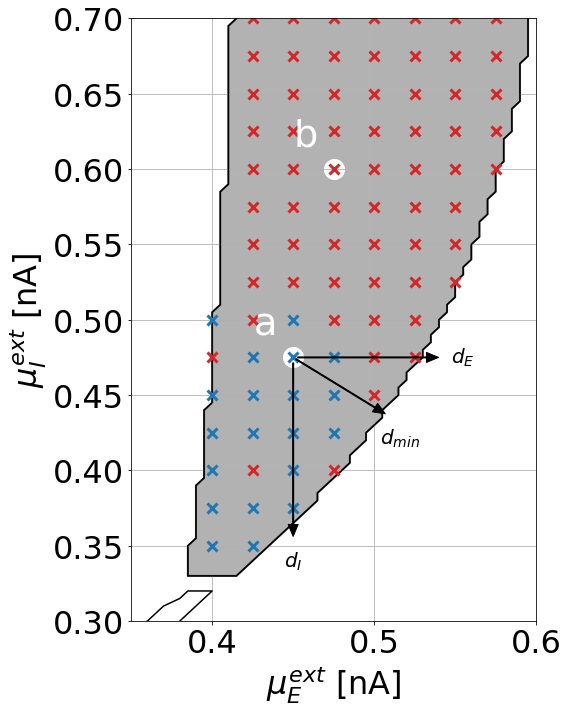

In [63]:
filename_ = 'bifurcation_task' + case + '_' + c_type + '.jpg'

fig, ax = plt.subplots(figsize = (8,10), facecolor=facecolor_)
ax.set_ylim(0.3, .7)
ax.set_xlim(0.35, .6)
#ax.set_xticks(np.arange(0.3, 0.8, 0.1))
#ax.set_yticks(np.arange(0.3, 0.8, 0.1))

vertices = np.zeros(( len(boundary_bi_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_bi_exc[i]
    vertices[i,1] = boundary_bi_inh[i]
path = mpath.Path(vertices)

patch = patches.PathPatch(path, facecolor='grey', alpha=0.6, lw=2)
ax.add_patch(patch)

x, y = zip(*path.vertices)
line, = ax.plot(x, y, markersize=0, color='black')

vertices = np.zeros(( len(boundary_LC_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_LC_exc[i]
    vertices[i,1] = boundary_LC_inh[i]
path = mpath.Path(vertices)
x, y = zip(*path.vertices)
line, = ax.plot(x, y, color='black')

bistable_regime = layout.get_bistable_paths(boundary_bi_exc, boundary_bi_inh)
oscillatory_regime = layout.get_osc_path(boundary_LC_exc, boundary_LC_inh)
LC_up_regime = layout.get_LC_up_path(boundary_LC_up_exc, boundary_LC_up_inh)

for i in range(len(ext_exc)):
    if type(a_e[i]) == type(None):
        continue

    if type_[i] in [0,2,4]:
        ax.plot(ext_exc[i], ext_inh[i], 'x', color=exc_red, markersize=10, markeredgewidth=3)
    elif type_[i] in [1,3,5]:
        ax.plot(ext_exc[i], ext_inh[i], 'x', color=inh_blue, markersize=10, markeredgewidth=3)
        
    if 

x_ = ext_exc[20]
y_ = ext_inh[20]
ax.plot(x_, y_, 'o', color=facecolor_, markersize=20, zorder=1)
ax.annotate('a', xy=(x_, y_),  xycoords='data',
        xytext=(x_ - 0.01, y_ + 0.01), textcoords='data', fontsize=1.2*fontsize_,
        horizontalalignment='right', verticalalignment='bottom', color='white'
        )
        
ax.annotate('', xy=(x_ + d_e[20], y_),  xycoords='data',
        xytext=(x_, y_), textcoords='data', fontsize=fontsize_small,
        arrowprops=dict(facecolor='black', shrink=0.03, headwidth=10, width=1),
        horizontalalignment='right', verticalalignment='bottom'
        )
ax.annotate('', xy=(x_ , y_ - d_i[20]),  xycoords='data',
        xytext=(x_, y_), textcoords='data', fontsize=fontsize_small,
        arrowprops=dict(facecolor='black', shrink=0.03, headwidth=10, width=1),
        horizontalalignment='right', verticalalignment='bottom'
        )
ax.annotate('', xy=(x_ + d_total[20]/np.sqrt(2.) + 0.01, y_ - d_total[20]/np.sqrt(2.) + 0.01),  xycoords='data',
        xytext=(x_, y_), textcoords='data', fontsize=fontsize_small, arrowprops=dict(facecolor='black', shrink=0.03,
        headwidth=10, width=1), horizontalalignment='right', verticalalignment='bottom'
        )
ax.annotate(r'$d_E$', xy=(x_ + d_e[20] + 0.005, y_),  xycoords='data',
        xytext=(x_ + d_e[20] + 0.005, y_), textcoords='data', fontsize=fontsize_small,
        horizontalalignment='left', verticalalignment='center'
        )
ax.annotate(r'$d_I$', xy=(x_, y_ - d_i[20] - 0.005),  xycoords='data',
        xytext=(x_, y_ - d_i[20] - 0.005), textcoords='data', fontsize=fontsize_small,
        horizontalalignment='center', verticalalignment='top'
        )
ax.annotate(r'$d_{min}$', xy=(x_ + d_total[20]/np.sqrt(2.) + 0.005, y_ - d_total[20]/np.sqrt(2.) - 0.005), 
        xycoords='data', xytext=(x_ + d_total[20]/np.sqrt(2.) + 0.005, y_ - d_total[20]/np.sqrt(2.) - 0.005),
        textcoords='data', fontsize=fontsize_small, horizontalalignment='left', verticalalignment='center'
        )

x_ = ext_exc[50]
y_ = ext_inh[50]
ax.plot(x_, y_, 'o', color=facecolor_, markersize=20, zorder=1)
ax.annotate('b', xy=(x_, y_),  xycoords='data',
        xytext=(x_ - 0.01, y_ + 0.01), textcoords='data', fontsize=1.2*fontsize_,
        horizontalalignment='right', verticalalignment='bottom', color='white'
        )

ax.set_xlabel(r'$\mu_E^{ext}$ [nA]', fontsize=fontsize_)
ax.set_ylabel(r'$\mu_I^{ext}$ [nA]', fontsize=fontsize_)
ax.tick_params(axis='x', labelsize=fontsize_)
ax.tick_params(axis='y', labelsize=fontsize_)

fig.tight_layout()
        
plt.savefig(os.path.join(os.getcwd(), filename_), bbox_inches='tight',
            facecolor=fig.get_facecolor(), edgecolor='none', dpi=300 )
plt.savefig(os.path.join(savepath, filename_), bbox_inches='tight',
            facecolor=fig.get_facecolor(), edgecolor='none', dpi=300 )

case =  ./data_final_rate/ 1
case =  ./data_final_rate/ 1


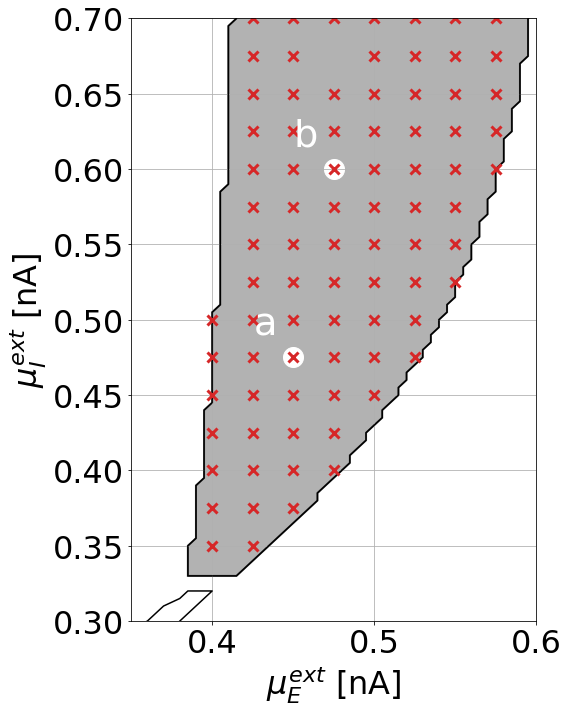

In [10]:
case = '1'
c_type = 'rate'
readpath = '.' + os.sep + 'data_final_' + c_type + os.sep
readcase(case, readpath)

filename_ = 'bifurcation_task' + case + '_' + c_type + '.jpg'

fig, ax = plt.subplots(figsize = (8,10), facecolor=facecolor_)
ax.set_ylim(0.3, .7)
ax.set_xlim(0.35, .6)
#ax.set_xticks(np.arange(0.3, 0.8, 0.1))
#ax.set_yticks(np.arange(0.3, 0.8, 0.1))

vertices = np.zeros(( len(boundary_bi_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_bi_exc[i]
    vertices[i,1] = boundary_bi_inh[i]
path = mpath.Path(vertices)

patch = patches.PathPatch(path, facecolor='grey', alpha=0.6, lw=2)
ax.add_patch(patch)

x, y = zip(*path.vertices)
line, = ax.plot(x, y, markersize=0, color='black')

vertices = np.zeros(( len(boundary_LC_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_LC_exc[i]
    vertices[i,1] = boundary_LC_inh[i]
path = mpath.Path(vertices)
x, y = zip(*path.vertices)
line, = ax.plot(x, y, color='black')

bistable_regime = layout.get_bistable_paths(boundary_bi_exc, boundary_bi_inh)
oscillatory_regime = layout.get_osc_path(boundary_LC_exc, boundary_LC_inh)
LC_up_regime = layout.get_LC_up_path(boundary_LC_up_exc, boundary_LC_up_inh)

for i in range(len(ext_exc)):
    if type(a_e[i]) == type(None):
        continue

    if type_[i] in [0,2,4]:
        ax.plot(ext_exc[i], ext_inh[i], 'x', color=exc_red, markersize=10, markeredgewidth=3)
    elif type_[i] in [1,3,5]:
        ax.plot(ext_exc[i], ext_inh[i], 'x', color=inh_blue, markersize=10, markeredgewidth=3)
        
x_ = ext_exc[20]
y_ = ext_inh[20]
ax.plot(x_, y_, 'o', color=facecolor_, markersize=20, zorder=1)
ax.annotate('a', xy=(x_, y_),  xycoords='data',
        xytext=(x_ - 0.01, y_ + 0.01), textcoords='data', fontsize=1.2*fontsize_,
        horizontalalignment='right', verticalalignment='bottom', color='white'
        )
x_ = ext_exc[50]
y_ = ext_inh[50]
ax.plot(x_, y_, 'o', color=facecolor_, markersize=20, zorder=1)
ax.annotate('b', xy=(x_, y_),  xycoords='data',
        xytext=(x_ - 0.01, y_ + 0.01), textcoords='data', fontsize=1.2*fontsize_,
        horizontalalignment='right', verticalalignment='bottom', color='white'
        )
        
ax.set_xlabel(r'$\mu_E^{ext}$ [nA]', fontsize=fontsize_)
ax.set_ylabel(r'$\mu_I^{ext}$ [nA]', fontsize=fontsize_)
ax.tick_params(axis='x', labelsize=fontsize_)
ax.tick_params(axis='y', labelsize=fontsize_)

fig.tight_layout()
        
plt.savefig(os.path.join(os.getcwd(), filename_), bbox_inches='tight',
            facecolor=fig.get_facecolor(), edgecolor='none', dpi=300 )
plt.savefig(os.path.join(savepath, filename_), bbox_inches='tight',
            facecolor=fig.get_facecolor(), edgecolor='none', dpi=300 )

In [38]:
case = '2'
c_type = 'current'
readpath = '.' + os.sep + 'data_final_' + c_type + os.sep
readcase(case, readpath)

case =  ./data_final_current/ 2
case =  ./data_final_current/ 2
Control amplitude beyond maximal synaptic current,  5
0.2607107332151775 2.43
-1.4355556650105019e-05 -3.3
0.0 2.6
-0.3949025578321872 -1.64
Control amplitude beyond maximal synaptic current,  9
0.34376871831630174 2.43
-6.56201919540199e-05 -3.3
0.0 2.6
-0.5217936038859201 -1.64
Control amplitude beyond maximal synaptic current,  10
0.26928934713877745 2.43
0.0 -3.3
0.0 2.6
-0.41578462940088684 -1.64
Control amplitude beyond maximal synaptic current,  11
0.19925504080192125 2.43
-2.3318883514307606e-25 -3.3
3.84844862703336e-13 2.6
-0.28913062712014 -1.64
Control amplitude beyond maximal synaptic current,  13
0.4336040423102002 2.43
-0.00011946634605106128 -3.3
0.0 2.6
-0.6603205825127546 -1.64
Control amplitude beyond maximal synaptic current,  14
0.35686626826211376 2.43
0.0 -3.3
0.0 2.6
-0.5512605607835175 -1.64
Control amplitude beyond maximal synaptic current,  15
0.2846062470726527 2.43
0.0 -3.3
0.0 2.6
-0.421603008

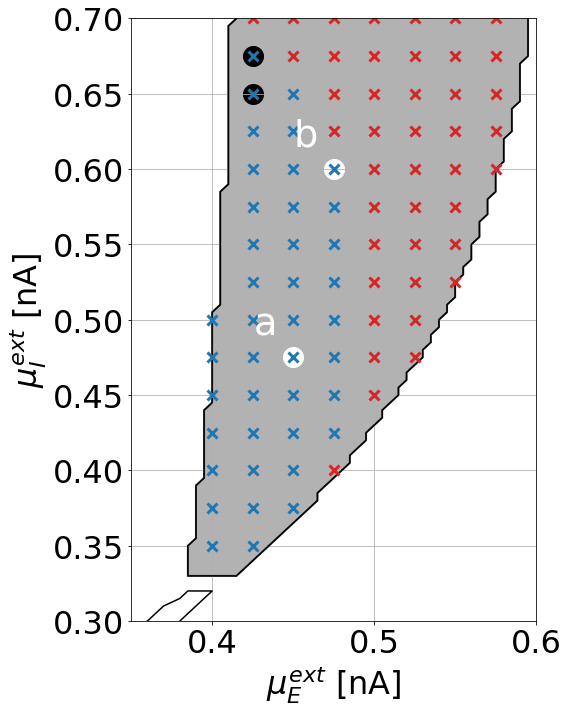

In [32]:
filename_ = 'bifurcation_task' + case + '_' + c_type + '.jpg'

fig, ax = plt.subplots(figsize = (8,10), facecolor=facecolor_)
ax.set_ylim(0.3, .7)
ax.set_xlim(0.35, .6)
#ax.set_xticks(np.arange(0.3, 0.8, 0.1))
#ax.set_yticks(np.arange(0.3, 0.8, 0.1))

vertices = np.zeros(( len(boundary_bi_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_bi_exc[i]
    vertices[i,1] = boundary_bi_inh[i]
path = mpath.Path(vertices)

patch = patches.PathPatch(path, facecolor='grey', alpha=0.6, lw=2)
ax.add_patch(patch)

x, y = zip(*path.vertices)
line, = ax.plot(x, y, markersize=0, color='black')

vertices = np.zeros(( len(boundary_LC_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_LC_exc[i]
    vertices[i,1] = boundary_LC_inh[i]
path = mpath.Path(vertices)
x, y = zip(*path.vertices)
line, = ax.plot(x, y, color='black')

bistable_regime = layout.get_bistable_paths(boundary_bi_exc, boundary_bi_inh)
oscillatory_regime = layout.get_osc_path(boundary_LC_exc, boundary_LC_inh)
LC_up_regime = layout.get_LC_up_path(boundary_LC_up_exc, boundary_LC_up_inh)

for i in range(len(ext_exc)):
    if type(a_e[i]) == type(None):
        continue

    if type_[i] in [0,2,4]:
        ax.plot(ext_exc[i], ext_inh[i], 'x', color=exc_red, markersize=10, markeredgewidth=3)
    elif type_[i] in [1,3,5]:
        ax.plot(ext_exc[i], ext_inh[i], 'x', color=inh_blue, markersize=10, markeredgewidth=3)

x_ = ext_exc[20]
y_ = ext_inh[20]
ax.plot(x_, y_, 'o', color=facecolor_, markersize=20, zorder=1)
ax.annotate('a', xy=(x_, y_),  xycoords='data',
        xytext=(x_ - 0.01, y_ + 0.01), textcoords='data', fontsize=1.2*fontsize_,
        horizontalalignment='right', verticalalignment='bottom', color='white'
        )
x_ = ext_exc[50]
y_ = ext_inh[50]
ax.plot(x_, y_, 'o', color=facecolor_, markersize=20, zorder=1)
ax.annotate('b', xy=(x_, y_),  xycoords='data',
        xytext=(x_ - 0.01, y_ + 0.01), textcoords='data', fontsize=1.2*fontsize_,
        horizontalalignment='right', verticalalignment='bottom', color='white'
        )

x_ = ext_exc[62]
y_ = ext_inh[62]
ax.plot(x_, y_, 'o', color='black', markersize=20, zorder=1)

x_ = ext_exc[69]
y_ = ext_inh[69]
ax.plot(x_, y_, 'o', color='black', markersize=20, zorder=1)
        
ax.set_xlabel(r'$\mu_E^{ext}$ [nA]', fontsize=fontsize_)
ax.set_ylabel(r'$\mu_I^{ext}$ [nA]', fontsize=fontsize_)
ax.tick_params(axis='x', labelsize=fontsize_)
ax.tick_params(axis='y', labelsize=fontsize_)

fig.tight_layout()
        
plt.savefig(os.path.join(os.getcwd(), filename_), bbox_inches='tight',
            facecolor=fig.get_facecolor(), edgecolor='none', dpi=300 )
plt.savefig(os.path.join(savepath, filename_), bbox_inches='tight',
            facecolor=fig.get_facecolor(), edgecolor='none', dpi=300 )

case =  ./data_final_rate/ 2
case =  ./data_final_rate/ 2


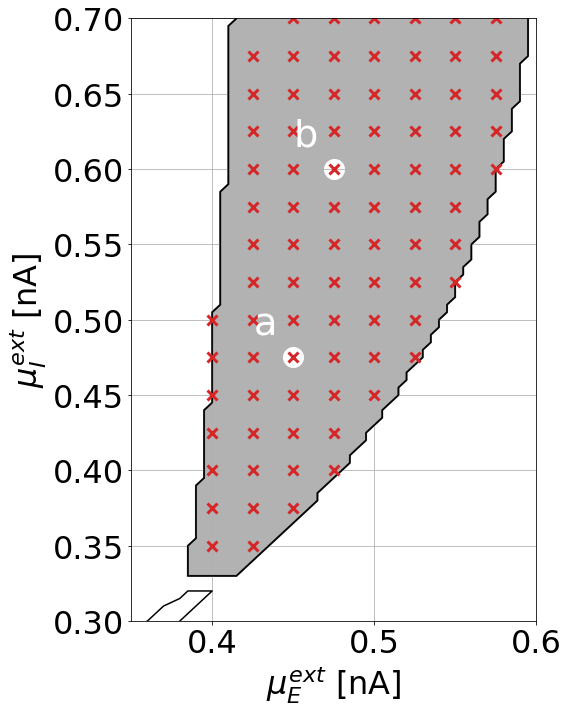

In [9]:
case = '2'
c_type = 'rate'
readpath = '.' + os.sep + 'data_final_' + c_type + os.sep
readcase(case, readpath)

filename_ = 'bifurcation_task' + case + '_' + c_type + '.jpg'

fig, ax = plt.subplots(figsize = (8,10), facecolor=facecolor_)
ax.set_ylim(0.3, .7)
ax.set_xlim(0.35, .6)
#ax.set_xticks(np.arange(0.3, 0.8, 0.1))
#ax.set_yticks(np.arange(0.3, 0.8, 0.1))

vertices = np.zeros(( len(boundary_bi_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_bi_exc[i]
    vertices[i,1] = boundary_bi_inh[i]
path = mpath.Path(vertices)

patch = patches.PathPatch(path, facecolor='grey', alpha=0.6, lw=2)
ax.add_patch(patch)

x, y = zip(*path.vertices)
line, = ax.plot(x, y, markersize=0, color='black')

vertices = np.zeros(( len(boundary_LC_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_LC_exc[i]
    vertices[i,1] = boundary_LC_inh[i]
path = mpath.Path(vertices)
x, y = zip(*path.vertices)
line, = ax.plot(x, y, color='black')

bistable_regime = layout.get_bistable_paths(boundary_bi_exc, boundary_bi_inh)
oscillatory_regime = layout.get_osc_path(boundary_LC_exc, boundary_LC_inh)
LC_up_regime = layout.get_LC_up_path(boundary_LC_up_exc, boundary_LC_up_inh)

for i in range(len(ext_exc)):
    if type(a_e[i]) == type(None):
        continue

    if type_[i] in [0,2,4]:
        ax.plot(ext_exc[i], ext_inh[i], 'x', color=exc_red, markersize=10, markeredgewidth=3)
    elif type_[i] in [1,3,5]:
        ax.plot(ext_exc[i], ext_inh[i], 'x', color=inh_blue, markersize=10, markeredgewidth=3)

x_ = ext_exc[20]
y_ = ext_inh[20]
ax.plot(x_, y_, 'o', color=facecolor_, markersize=20, zorder=1)
ax.annotate('a', xy=(x_, y_),  xycoords='data',
        xytext=(x_ - 0.01, y_ + 0.01), textcoords='data', fontsize=1.2*fontsize_,
        horizontalalignment='right', verticalalignment='bottom', color='white'
        )
x_ = ext_exc[50]
y_ = ext_inh[50]
ax.plot(x_, y_, 'o', color=facecolor_, markersize=20, zorder=1)
ax.annotate('b', xy=(x_, y_),  xycoords='data',
        xytext=(x_ - 0.01, y_ + 0.01), textcoords='data', fontsize=1.2*fontsize_,
        horizontalalignment='right', verticalalignment='bottom', color='white'
        )
        
ax.set_xlabel(r'$\mu_E^{ext}$ [nA]', fontsize=fontsize_)
ax.set_ylabel(r'$\mu_I^{ext}$ [nA]', fontsize=fontsize_)
ax.tick_params(axis='x', labelsize=fontsize_)
ax.tick_params(axis='y', labelsize=fontsize_)

fig.tight_layout()
        
plt.savefig(os.path.join(os.getcwd(), filename_), bbox_inches='tight',
            facecolor=fig.get_facecolor(), edgecolor='none', dpi=300 )
plt.savefig(os.path.join(savepath, filename_), bbox_inches='tight',
            facecolor=fig.get_facecolor(), edgecolor='none', dpi=300 )

In [39]:
case = '3'
c_type = 'current'
readpath = '.' + os.sep + 'data_final_' + c_type + os.sep
readcase(case, readpath)

case =  ./data_final_current/ 3
case =  ./data_final_current/ 3
Control amplitude beyond maximal synaptic current,  1
0.0007132875272053155 2.43
-0.40703767935117824 -3.3
4.410137489313102e-13 2.6
-2.7038187408373286e-13 -1.64
Control amplitude beyond maximal synaptic current,  3
2.537202534418078e-12 2.43
-0.38493997936686664 -3.3
3.772631310639768e-14 2.6
-1.844590696064756e-12 -1.64
Control amplitude beyond maximal synaptic current,  4
5.4549286648159306e-05 2.43
-0.6315541698274447 -3.3
0.0 2.6
0.0 -1.64
Control amplitude beyond maximal synaptic current,  6
0.005951379335700967 2.43
-0.3471398545243224 -3.3
0.0 2.6
0.0 -1.64
Control amplitude beyond maximal synaptic current,  7
1.7292772133819386e-16 2.43
-0.6002259687798059 -3.3
0.0 2.6
0.0 -1.64
Control amplitude beyond maximal synaptic current,  8
3.4893401898794416e-05 2.43
-0.8656836711132271 -3.3
1.0172262428913033e-10 2.6
-1.1795062146146742e-11 -1.64
Control amplitude beyond maximal synaptic current,  10
0.0 2.43
-0.3231343

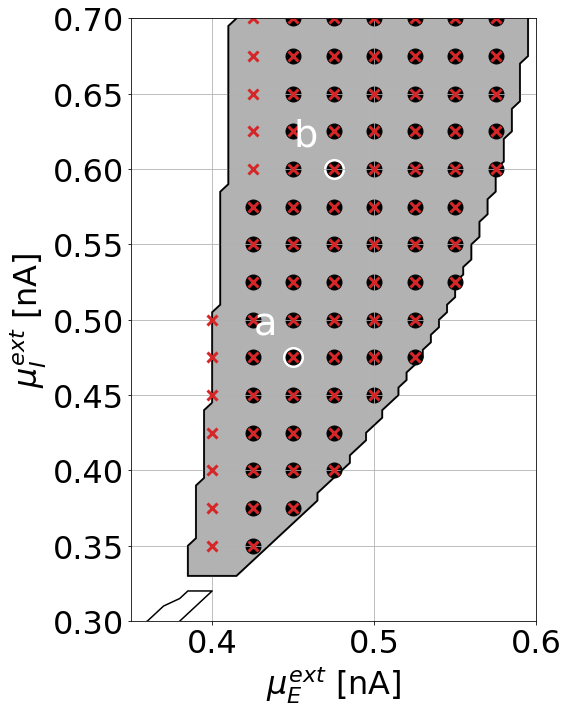

In [43]:
filename_ = 'bifurcation_task' + case + '_' + c_type + '.jpg'

fig, ax = plt.subplots(figsize = (8,10), facecolor=facecolor_)
ax.set_ylim(0.3, .7)
ax.set_xlim(0.35, .6)
#ax.set_xticks(np.arange(0.3, 0.8, 0.1))
#ax.set_yticks(np.arange(0.3, 0.8, 0.1))

vertices = np.zeros(( len(boundary_bi_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_bi_exc[i]
    vertices[i,1] = boundary_bi_inh[i]
path = mpath.Path(vertices)

patch = patches.PathPatch(path, facecolor='grey', alpha=0.6, lw=2)
ax.add_patch(patch)

x, y = zip(*path.vertices)
line, = ax.plot(x, y, markersize=0, color='black')

vertices = np.zeros(( len(boundary_LC_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_LC_exc[i]
    vertices[i,1] = boundary_LC_inh[i]
path = mpath.Path(vertices)
x, y = zip(*path.vertices)
line, = ax.plot(x, y, color='black')

bistable_regime = layout.get_bistable_paths(boundary_bi_exc, boundary_bi_inh)
oscillatory_regime = layout.get_osc_path(boundary_LC_exc, boundary_LC_inh)
LC_up_regime = layout.get_LC_up_path(boundary_LC_up_exc, boundary_LC_up_inh)

for i in range(len(ext_exc)):
    if type(a_e[i]) == type(None):
        continue

    if type_[i] in [0,2,4]:
        ax.plot(ext_exc[i], ext_inh[i], 'x', color=exc_red, markersize=10, markeredgewidth=3)
    elif type_[i] in [1,3,5]:
        ax.plot(ext_exc[i], ext_inh[i], 'x', color=inh_blue, markersize=10, markeredgewidth=3)

x_ = ext_exc[20]
y_ = ext_inh[20]
ax.plot(x_, y_, 'o', color=facecolor_, markersize=20, zorder=1)
ax.annotate('a', xy=(x_, y_),  xycoords='data',
        xytext=(x_ - 0.01, y_ + 0.01), textcoords='data', fontsize=1.2*fontsize_,
        horizontalalignment='right', verticalalignment='bottom', color='white'
        )
x_ = ext_exc[50]
y_ = ext_inh[50]
ax.plot(x_, y_, 'o', color=facecolor_, markersize=20, zorder=1)
ax.annotate('b', xy=(x_, y_),  xycoords='data',
        xytext=(x_ - 0.01, y_ + 0.01), textcoords='data', fontsize=1.2*fontsize_,
        horizontalalignment='right', verticalalignment='bottom', color='white'
        )

for i in [1, 3, 4, 6, 7, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32,
          33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59,
         60, 61, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82]:
    x_ = ext_exc[i]
    y_ = ext_inh[i]
    ax.plot(x_, y_, 'o', color='black', markersize=15, zorder=1)
        
ax.set_xlabel(r'$\mu_E^{ext}$ [nA]', fontsize=fontsize_)
ax.set_ylabel(r'$\mu_I^{ext}$ [nA]', fontsize=fontsize_)
ax.tick_params(axis='x', labelsize=fontsize_)
ax.tick_params(axis='y', labelsize=fontsize_)

fig.tight_layout()
        
plt.savefig(os.path.join(os.getcwd(), filename_), bbox_inches='tight',
            facecolor=fig.get_facecolor(), edgecolor='none', dpi=300 )
plt.savefig(os.path.join(savepath, filename_), bbox_inches='tight',
            facecolor=fig.get_facecolor(), edgecolor='none', dpi=300 )

case =  ./data_final_rate/ 3
case =  ./data_final_rate/ 3


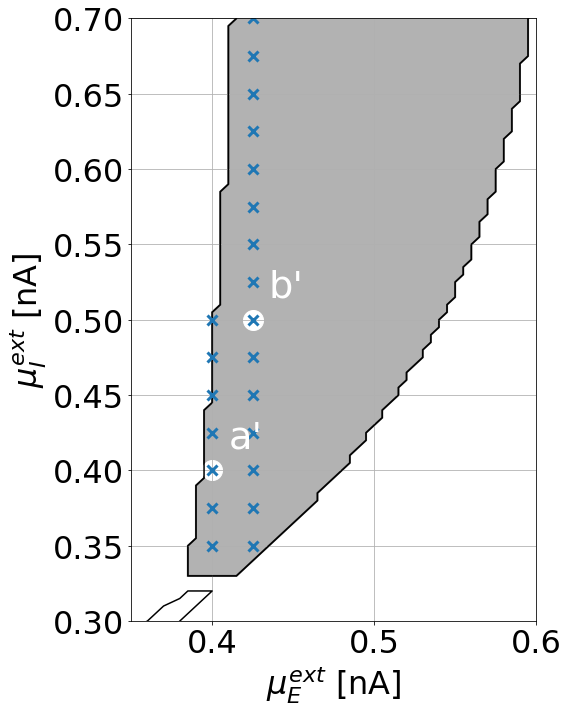

In [68]:
case = '3'
c_type = 'rate'
readpath = '.' + os.sep + 'data_final_' + c_type + os.sep
readcase(case, readpath)

filename_ = 'bifurcation_task' + case + '_' + c_type + '.jpg'

fig, ax = plt.subplots(figsize = (8,10), facecolor=facecolor_)
ax.set_ylim(0.3, .7)
ax.set_xlim(0.35, .6)
#ax.set_xticks(np.arange(0.3, 0.8, 0.1))
#ax.set_yticks(np.arange(0.3, 0.8, 0.1))

vertices = np.zeros(( len(boundary_bi_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_bi_exc[i]
    vertices[i,1] = boundary_bi_inh[i]
path = mpath.Path(vertices)

patch = patches.PathPatch(path, facecolor='grey', alpha=0.6, lw=2)
ax.add_patch(patch)

x, y = zip(*path.vertices)
line, = ax.plot(x, y, markersize=0, color='black')

vertices = np.zeros(( len(boundary_LC_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_LC_exc[i]
    vertices[i,1] = boundary_LC_inh[i]
path = mpath.Path(vertices)
x, y = zip(*path.vertices)
line, = ax.plot(x, y, color='black')

bistable_regime = layout.get_bistable_paths(boundary_bi_exc, boundary_bi_inh)
oscillatory_regime = layout.get_osc_path(boundary_LC_exc, boundary_LC_inh)
LC_up_regime = layout.get_LC_up_path(boundary_LC_up_exc, boundary_LC_up_inh)

for i in range(len(ext_exc)):
    if type(a_e[i]) == type(None):
        continue

    if type_[i] in [0,2,4]:
        ax.plot(ext_exc[i], ext_inh[i], 'x', color=exc_red, markersize=10, markeredgewidth=3)
    elif type_[i] in [1,3,5]:
        ax.plot(ext_exc[i], ext_inh[i], 'x', color=inh_blue, markersize=10, markeredgewidth=3)

x_ = ext_exc[5]
y_ = ext_inh[5]
ax.plot(x_, y_, 'o', color=facecolor_, markersize=20, zorder=1)
ax.annotate('a\'', xy=(x_, y_),  xycoords='data',
        xytext=(x_ + 0.01, y_ + 0.01), textcoords='data', fontsize=1.2*fontsize_,
        horizontalalignment='left', verticalalignment='bottom', color='white'
        )
x_ = ext_exc[25]
y_ = ext_inh[25]
ax.plot(x_, y_, 'o', color=facecolor_, markersize=20, zorder=1)
ax.annotate('b\'', xy=(x_, y_),  xycoords='data',
        xytext=(x_ + 0.01, y_ + 0.01), textcoords='data', fontsize=1.2*fontsize_,
        horizontalalignment='left', verticalalignment='bottom', color='white'
        )
        
ax.set_xlabel(r'$\mu_E^{ext}$ [nA]', fontsize=fontsize_)
ax.set_ylabel(r'$\mu_I^{ext}$ [nA]', fontsize=fontsize_)
ax.tick_params(axis='x', labelsize=fontsize_)
ax.tick_params(axis='y', labelsize=fontsize_)

fig.tight_layout()
        
plt.savefig(os.path.join(os.getcwd(), filename_), bbox_inches='tight',
            facecolor=fig.get_facecolor(), edgecolor='none', dpi=300 )
plt.savefig(os.path.join(savepath, filename_), bbox_inches='tight',
            facecolor=fig.get_facecolor(), edgecolor='none', dpi=300 )

case =  ./data_final_current/ 4
case =  ./data_final_current/ 4


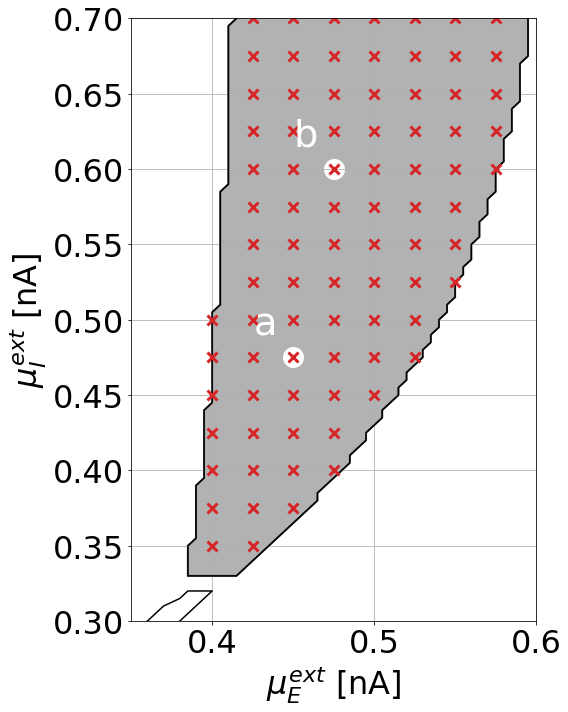

In [35]:
case = '4'
c_type = 'current'
readpath = '.' + os.sep + 'data_final_' + c_type + os.sep
readcase(case, readpath)

filename_ = 'bifurcation_task' + case + '_' + c_type + '.jpg'

fig, ax = plt.subplots(figsize = (8,10), facecolor=facecolor_)
ax.set_ylim(0.3, .7)
ax.set_xlim(0.35, .6)
#ax.set_xticks(np.arange(0.3, 0.8, 0.1))
#ax.set_yticks(np.arange(0.3, 0.8, 0.1))

vertices = np.zeros(( len(boundary_bi_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_bi_exc[i]
    vertices[i,1] = boundary_bi_inh[i]
path = mpath.Path(vertices)

patch = patches.PathPatch(path, facecolor='grey', alpha=0.6, lw=2)
ax.add_patch(patch)

x, y = zip(*path.vertices)
line, = ax.plot(x, y, markersize=0, color='black')

vertices = np.zeros(( len(boundary_LC_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_LC_exc[i]
    vertices[i,1] = boundary_LC_inh[i]
path = mpath.Path(vertices)
x, y = zip(*path.vertices)
line, = ax.plot(x, y, color='black')

bistable_regime = layout.get_bistable_paths(boundary_bi_exc, boundary_bi_inh)
oscillatory_regime = layout.get_osc_path(boundary_LC_exc, boundary_LC_inh)
LC_up_regime = layout.get_LC_up_path(boundary_LC_up_exc, boundary_LC_up_inh)

for i in range(len(ext_exc)):
    if type(a_e[i]) == type(None):
        continue

    if type_[i] in [0,2,4]:
        ax.plot(ext_exc[i], ext_inh[i], 'x', color=exc_red, markersize=10, markeredgewidth=3)
    elif type_[i] in [1,3,5]:
        ax.plot(ext_exc[i], ext_inh[i], 'x', color=inh_blue, markersize=10, markeredgewidth=3)

x_ = ext_exc[20]
y_ = ext_inh[20]
ax.plot(x_, y_, 'o', color=facecolor_, markersize=20, zorder=1)
ax.annotate('a', xy=(x_, y_),  xycoords='data',
        xytext=(x_ - 0.01, y_ + 0.01), textcoords='data', fontsize=1.2*fontsize_,
        horizontalalignment='right', verticalalignment='bottom', color='white'
        )
x_ = ext_exc[50]
y_ = ext_inh[50]
ax.plot(x_, y_, 'o', color=facecolor_, markersize=20, zorder=1)
ax.annotate('b', xy=(x_, y_),  xycoords='data',
        xytext=(x_ - 0.01, y_ + 0.01), textcoords='data', fontsize=1.2*fontsize_,
        horizontalalignment='right', verticalalignment='bottom', color='white'
        )
        
ax.set_xlabel(r'$\mu_E^{ext}$ [nA]', fontsize=fontsize_)
ax.set_ylabel(r'$\mu_I^{ext}$ [nA]', fontsize=fontsize_)
ax.tick_params(axis='x', labelsize=fontsize_)
ax.tick_params(axis='y', labelsize=fontsize_)

fig.tight_layout()
        
plt.savefig(os.path.join(os.getcwd(), filename_), bbox_inches='tight',
            facecolor=fig.get_facecolor(), edgecolor='none', dpi=300 )
plt.savefig(os.path.join(savepath, filename_), bbox_inches='tight',
            facecolor=fig.get_facecolor(), edgecolor='none', dpi=300 )

case =  ./data_final_rate/ 4
case =  ./data_final_rate/ 4


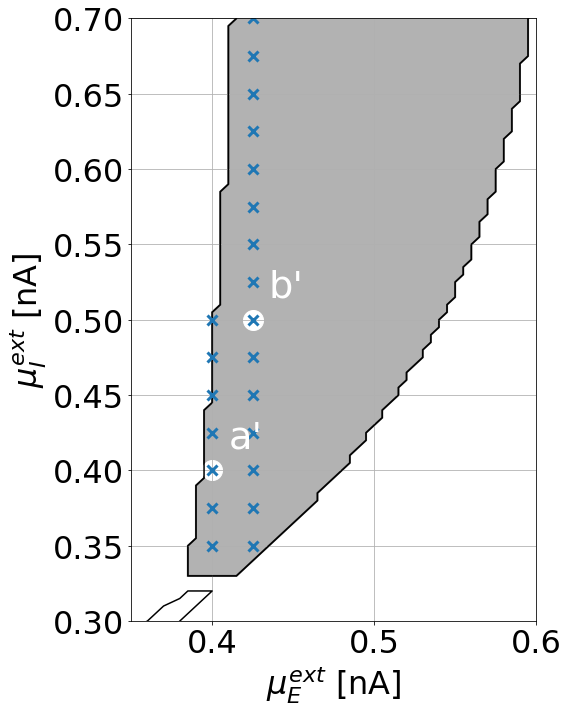

In [70]:
case = '4'
c_type = 'rate'
readpath = '.' + os.sep + 'data_final_' + c_type + os.sep
readcase(case, readpath)

filename_ = 'bifurcation_task' + case + '_' + c_type + '.jpg'

fig, ax = plt.subplots(figsize = (8,10), facecolor=facecolor_)
ax.set_ylim(0.3, .7)
ax.set_xlim(0.35, .6)
#ax.set_xticks(np.arange(0.3, 0.8, 0.1))
#ax.set_yticks(np.arange(0.3, 0.8, 0.1))

vertices = np.zeros(( len(boundary_bi_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_bi_exc[i]
    vertices[i,1] = boundary_bi_inh[i]
path = mpath.Path(vertices)

patch = patches.PathPatch(path, facecolor='grey', alpha=0.6, lw=2)
ax.add_patch(patch)

x, y = zip(*path.vertices)
line, = ax.plot(x, y, markersize=0, color='black')

vertices = np.zeros(( len(boundary_LC_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_LC_exc[i]
    vertices[i,1] = boundary_LC_inh[i]
path = mpath.Path(vertices)
x, y = zip(*path.vertices)
line, = ax.plot(x, y, color='black')

bistable_regime = layout.get_bistable_paths(boundary_bi_exc, boundary_bi_inh)
oscillatory_regime = layout.get_osc_path(boundary_LC_exc, boundary_LC_inh)
LC_up_regime = layout.get_LC_up_path(boundary_LC_up_exc, boundary_LC_up_inh)

for i in range(len(ext_exc)):
    if type(a_e[i]) == type(None):
        continue

    if type_[i] in [0,2,4]:
        ax.plot(ext_exc[i], ext_inh[i], 'x', color=exc_red, markersize=10, markeredgewidth=3)
    elif type_[i] in [1,3,5]:
        ax.plot(ext_exc[i], ext_inh[i], 'x', color=inh_blue, markersize=10, markeredgewidth=3)

x_ = ext_exc[5]
y_ = ext_inh[5]
ax.plot(x_, y_, 'o', color=facecolor_, markersize=20, zorder=1)
ax.annotate('a\'', xy=(x_, y_),  xycoords='data',
        xytext=(x_ + 0.01, y_ + 0.01), textcoords='data', fontsize=1.2*fontsize_,
        horizontalalignment='left', verticalalignment='bottom', color='white'
        )
x_ = ext_exc[25]
y_ = ext_inh[25]
ax.plot(x_, y_, 'o', color=facecolor_, markersize=20, zorder=1)
ax.annotate('b\'', xy=(x_, y_),  xycoords='data',
        xytext=(x_ + 0.01, y_ + 0.01), textcoords='data', fontsize=1.2*fontsize_,
        horizontalalignment='left', verticalalignment='bottom', color='white'
        )
        
ax.set_xlabel(r'$\mu_E^{ext}$ [nA]', fontsize=fontsize_)
ax.set_ylabel(r'$\mu_I^{ext}$ [nA]', fontsize=fontsize_)
ax.tick_params(axis='x', labelsize=fontsize_)
ax.tick_params(axis='y', labelsize=fontsize_)

fig.tight_layout()
        
plt.savefig(os.path.join(os.getcwd(), filename_), bbox_inches='tight',
            facecolor=fig.get_facecolor(), edgecolor='none', dpi=300 )
plt.savefig(os.path.join(savepath, filename_), bbox_inches='tight',
            facecolor=fig.get_facecolor(), edgecolor='none', dpi=300 )